# Loading and basic analysis preparation for ROMS

Loading ROMS data and preparing the dataset for basic analysis

## Background

The Regional Ocean Modelling System (ROMS) is a terrain-following coordinate primitive equation model, employing the Arakawa-C grid horizontal discretisation. This tutorial is loading output from a ROMS application to the Shackleton Ice Shelf / Denman Glacier region of East Antarctica, developed by David Gwyther (UQ). It uses ROMSIceShelf (lead developer: Ben Galton-Fenzi), which is available in a (public repository)[https://github.com/bkgf/ROMSIceShelf]. 

This model application has been developed to provide reasonable estimates of ice-ocean interaction beneath the Denman/Shackleton Ice Shelf, using a kernel and tuning parameters that have been widely tested for other ice-ocean applications (e.g. Amery, Totten, Mertz & Ninnis, Sorsdal, Vanderford and several circum-Antarctic applications).

In this tutorial, we will demonstrate the procedure for loading model history files, then extract some time-mean fields for plotting.


## Loading model output


We start by importing some useful packages.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean as cm
# import intake
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import xarray as xr
from xgcm import Grid

# from dask.distributed import Client



I found that sometimes dask doesn't play nice with xgcm, so let's not use dask for now. It's probably a version issue, but for now let's not use dask.

In [2]:
# client = Client(threads_per_worker=1)
# client

I get a lot of future and runtime warnings, so let's turn them off for now.

In [3]:
import warnings

warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=FutureWarning)

Open ACCESS-NRI default catalog

In [4]:
# catalog = intake.cat.access_nri

Choose the Shackleton ROMS output, which has 5-day snapshots.

In [5]:
# expt = '01deg_jra55v13_ryf9091'

<!-- For this recipe we will just load 1 year of daily velocities, but if you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`. -->

In [6]:
# start_time = '2100-12-01'
# end_time = '2100-12-31'

In [7]:
# darray = catalog[expt].search(
#                 variable = 'u',
#                 frequency = '1day',
#                 file_id = 'ocean_daily_3d_u').to_dask()
# u = darray['u'].sel(time = slice(start_time, end_time), yu_ocean = slice(None, -50))

# darray = catalog[expt].search(
#                 variable = 'v',
#                 frequency = '1day',
#                 file_id = 'ocean_daily_3d_v').to_dask()
# v = darray['v'].sel(time = slice(start_time, end_time), yu_ocean = slice(None, -50))

In [8]:
# simple method for loading his files - replace with intake catalog method.and
import glob
FilePath='/g/data/jk72/deg581/shacom/mdl/shackleton_v4/' # Truth file settings
prefix='roms_his_'


filelist = glob.glob(FilePath+prefix+'002*.nc')
ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

What does the dataset look like:

In [9]:
# The dataset has dimensions and coordinates
print('time dimension:', ds.dims['ocean_time'])
print('x dimension:', ds.dims['xi_rho'])
print('y dimension:', ds.dims['eta_rho'])
print('z dimension:', ds.dims['s_rho'])
print('time coordinate:', ds.coords['ocean_time'])

# it contains variables
print('it contains variables, for example:')
print('free-surface variable',ds.zeta)
print('u variable',ds.u)
print('melt rate variable',ds.m)
print('temperature variable',ds.temp)

# and attributes
print('attributes of the dataset:')
print('title:', ds.attrs['title'])
print('grd_file:', ds.attrs['grd_file'])
print('history:', ds.attrs['history'])

time dimension: 478
x dimension: 295
y dimension: 310
z dimension: 31
time coordinate: <xarray.DataArray 'ocean_time' (ocean_time: 478)> Size: 4kB
array(['2026-01-01T00:00:00.000000000', '2026-01-06T00:00:00.000000000',
       '2026-01-11T00:00:00.000000000', ..., '2032-07-03T00:00:00.000000000',
       '2032-07-08T00:00:00.000000000', '2032-07-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 4kB 2026-01-01 ... 2032-07-13
Attributes:
    standard_name:  time
    long_name:      time since initialization
    field:          time
it contains variables, for example:
free-surface variable <xarray.DataArray 'zeta' (ocean_time: 478, eta_rho: 310, xi_rho: 295)> Size: 175MB
dask.array<concatenate, shape=(478, 310, 295), dtype=float32, chunksize=(1, 310, 295), chunktype=numpy.ndarray>
Coordinates:
    x_rho       (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float

We need to process the dataset in a particular method in order to use it happily with `xgcm`. This involves creating a new dataset with the grid metrics and the grid object. This is a bit of a pain, but it's a one-off cost. We can then use this new dataset to do all our analysis. ROMS doesn't follow standard ESMF naming for some coordinates, so overwrite the offending names. We also use the vertical transformation to map from `s_rho` to `z_rho`. 

We also define a function for making an `xgcm` grid object, which can be used for making horizontal sections, interpolating, averaging etc and other nice QOL features.



In [10]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


In [11]:

ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

Let's make some masks that don't already exist

In [12]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files.

In [13]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')
ds_seas = ds.groupby('ocean_time.season').mean('ocean_time')


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

In [14]:

my = (ds_seas.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_seas.ubar, 'X')
vbar = grid.interp(ds_seas.vbar, 'Y')

temp = ds_seas.temp
salt = ds_seas.salt

In [15]:
ds_seas

<xarray.Dataset> Size: 1GB
Dimensions:        (season: 4, eta_rho: 310, xi_rho: 295, xi_u: 294,
                    eta_v: 309, s_rho: 31, s_w: 32, tracer: 2, boundary: 4)
Coordinates: (12/20)
  * s_rho          (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w            (s_w) float64 256B -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    y_rho          (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    ...             ...
    x_psi          (eta_v, xi_u) float64 727kB dask.array<chunksize=(309, 294), meta=np.ndarray>
    y_psi          (eta_v, xi_u) float64 727kB dask.array<chunksize=(309, 294), meta=np.ndarray>
    lon_psi        (eta_v, xi_u) float64 727kB dask.array<chunksize=(309, 294), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 727kB dask.array<chunksize=(309, 294), meta=np.ndarray>
    z_rho0         (eta_rho, xi_rho, s_rho) float64 23MB dask.array<chunksize=(310, 295, 31), meta=np.ndarray>
  * season         (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, tracer, boundary
Data variables: (12/112)
    m              (season, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    Tb             (season, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    Sb             (season, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    zeta           (season, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 310, 295), meta=np.ndarray>
    ubar           (season, eta_rho, xi_u) float32 1MB dask.array<chunksize=(1, 310, 294), meta=np.ndarray>
    vbar           (season, eta_v, xi_rho) float32 1MB dask.array<chunksize=(1, 309, 295), meta=np.ndarray>
    ...             ...
    dy             (season, eta_rho, xi_rho) float64 3MB dask.array<chunksize=(4, 310, 295), meta=np.ndarray>
    dy_u           (season, eta_rho, xi_u) float64 3MB dask.array<chunksize=(4, 310, 294), meta=np.ndarray>
    dy_v           (season, eta_v, xi_rho) float64 3MB dask.array<chunksize=(4, 309, 295), meta=np.ndarray>
    dy_psi         (season, eta_v, xi_u) float64 3MB dask.array<chunksize=(4, 309, 294), meta=np.ndarray>
    dA             (season, eta_rho, xi_rho) float64 3MB dask.array<chunksize=(4, 310, 295), meta=np.ndarray>
    dstart         (season) datetime64[ns] 32B 2007-01-01 ... 2007-01-01
Attributes: (12/35)
    file:              roms_his_0020.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            016x018
    history:           ROMS/TOMS, Version 4.1, Wednesday - January 22, 2025 -...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       SHACKLETON, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INI...

In [24]:
(ds.h)

<xarray.DataArray 'h' (eta_rho: 310, xi_rho: 295)> Size: 732kB
dask.array<open_dataset-h, shape=(310, 295), dtype=float64, chunksize=(310, 295), chunktype=numpy.ndarray>
Coordinates:
    x_rho    (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 732kB dask.array<chunksize=(310, 295), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    standard_name:  sea_floor_depth
    long_name:      bathymetry at RHO-points
    units:          meter
    grid:           grid
    location:       face
    field:          bathymetry

Let's make a nice bathymetry map


<Figure size 640x480 with 0 Axes>

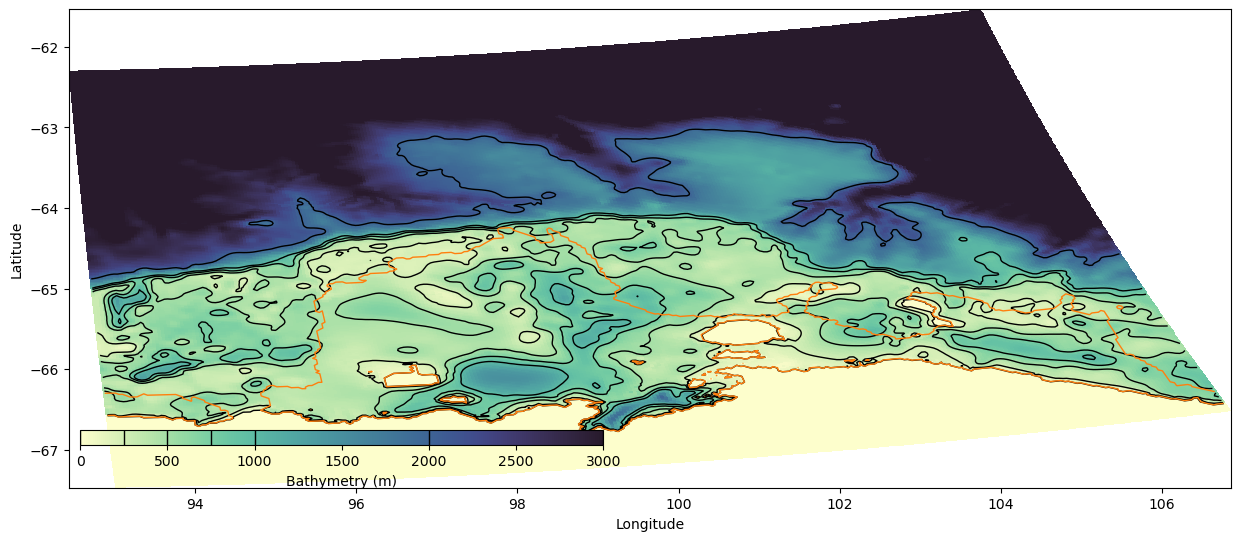

In [36]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])
ax = None

ax = fig.add_subplot(gs[0,0])
im = (ds.h*ds.mask_rho).plot(ax=ax, x='lon_rho',y='lat_rho', cmap=cm.cm.deep,add_colorbar=False)
co2 = (ds.h*ds.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.lon_rho,ds.lat_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#add colourbar
cax = inset_axes(ax,
                width="45%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,.09, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('Bathymetry (m)')

cbar.add_lines(co2)


And water column thickness

<Figure size 640x480 with 0 Axes>

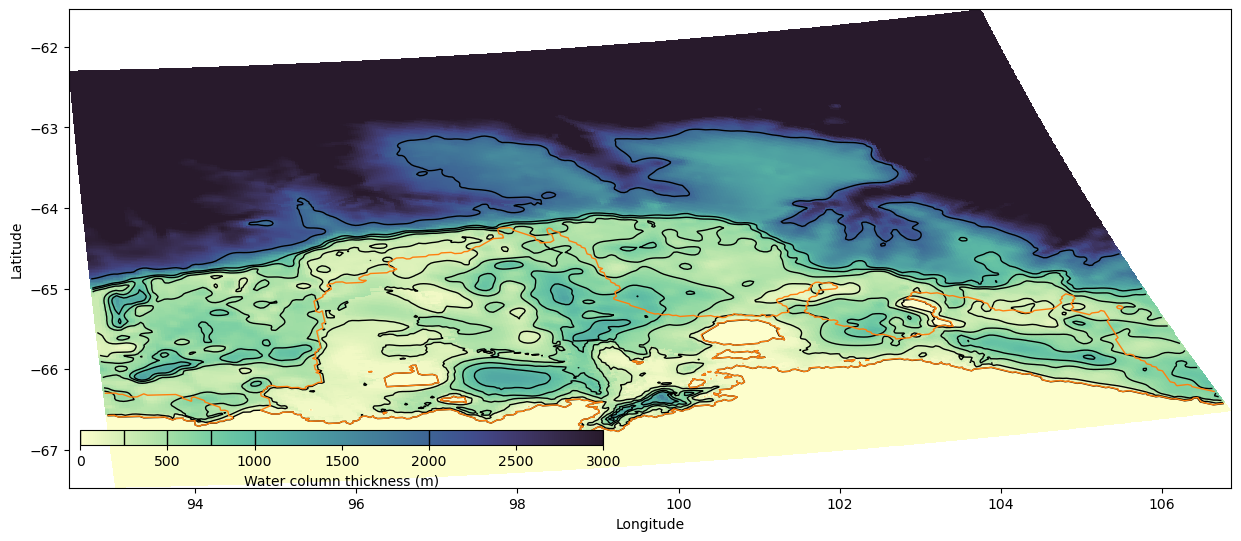

In [37]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])
ax = None

ax = fig.add_subplot(gs[0,0])
im = ((ds.h+ds.zice)*ds.mask_rho).plot(ax=ax, x='lon_rho',y='lat_rho', cmap=cm.cm.deep,add_colorbar=False)
co2 = ((ds.h+ds.zice)*ds.mask_rho).plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds.lon_rho,ds.lat_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C1',linestyles='-',linewidths=1)
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#add colourbar
cax = inset_axes(ax,
                width="45%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,.09, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('Water column thickness (m)')

cbar.add_lines(co2)


Now make some annual and seasonal mean spatial plots

<Figure size 640x480 with 0 Axes>

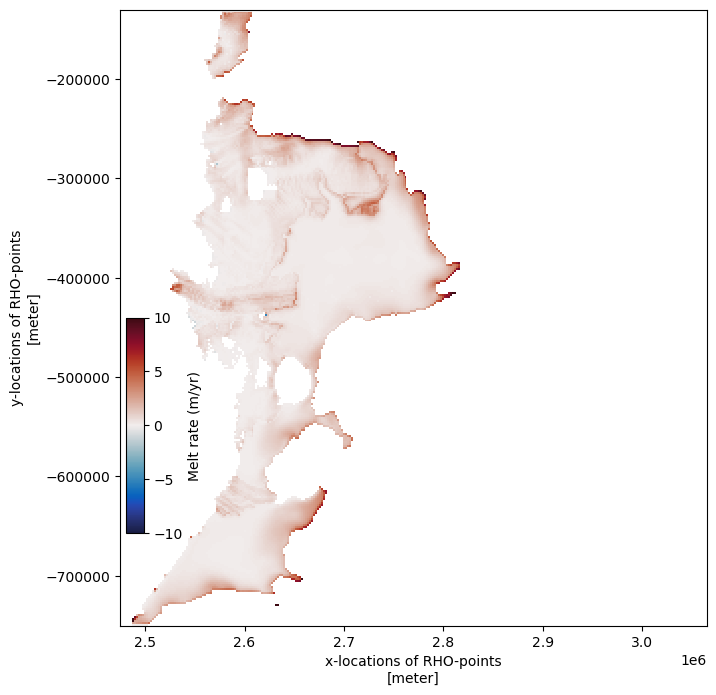

In [16]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0])
im = (my.mean(dim='season')*mask_ziceNaN).plot(ax=ax, x='x_rho',y='y_rho', vmin=-10, vmax=10, cmap=cm.cm.balance,add_colorbar=False)
ax.set_aspect('equal')

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="35%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cbar.set_label('Melt rate (m/yr)')
ax = plt.gca()



<Figure size 640x480 with 0 Axes>

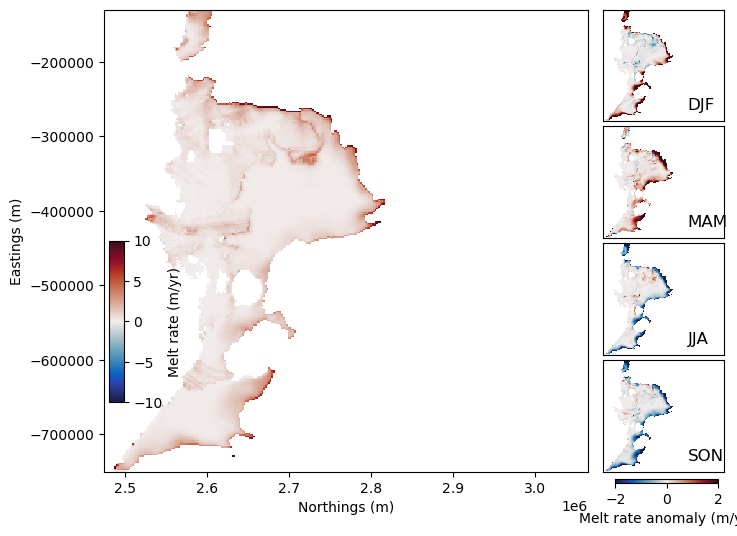

In [17]:


gs = gridspec.GridSpec(nrows=4,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[.8,.2])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None

ax = fig.add_subplot(gs[:,0])
im = (my.mean(dim='season')*mask_ziceNaN).plot(ax=ax, x='x_rho',y='y_rho', vmin=-10, vmax=10, cmap=cm.cm.balance,add_colorbar=False)
ax.set_xlabel('Northings (m)')
ax.set_ylabel('Eastings (m)')

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="35%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cbar.set_label('Melt rate (m/yr)')
ax = plt.gca()

seasons = ['DJF','MAM','JJA','SON']
for i,season in enumerate(seasons):
    ax = fig.add_subplot(gs[i,1])
    im = (my.sel(season=season)*mask_ziceNaN - my.mean(dim='season')).plot(ax=ax, x='x_rho',y='y_rho', vmin=-2, vmax=2, cmap=cm.cm.balance,add_colorbar=False)
    ax.set_title('')
    ax.text(0.7, 0.1, season, fontsize=12, transform=ax.transAxes)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

#add colourbar
cax = inset_axes(ax,
                width="85%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,-.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('Melt rate anomaly (m/yr)')
ax = plt.gca()



We see that annual mean melt rate is highest at (a) the ice front and (b) the grounding line beneath Denman Glacier. There is also a clear seasonal signal in the melt rate, with seasonability visible at the ice front and also beneath the deeper ice.

Let's delve into the seasonality a little bit deeper, by plotting up the mean melt rates for shallow ice and for the deeper ice. First, let's plot the ice depth and distribution.

Text(0, 0.5, 'Frequency')

<Figure size 640x480 with 0 Axes>

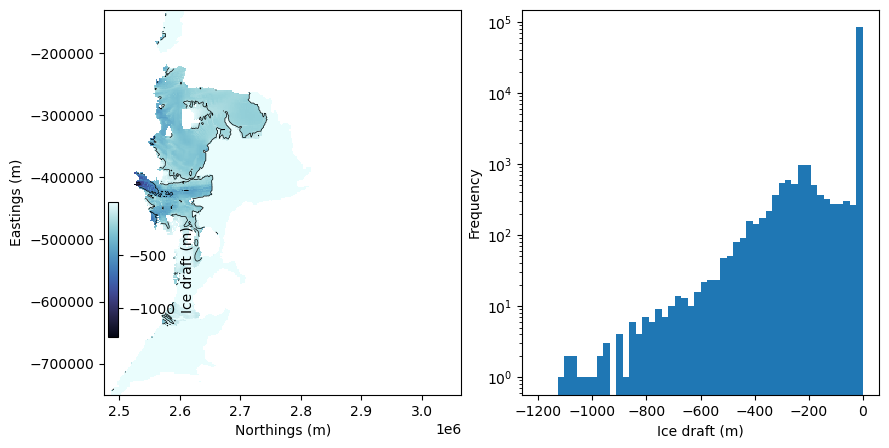

In [18]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None


ax = fig.add_subplot(gs[0,0])
im = (ds.zice*mask_ziceNaN).plot(ax=ax, x='x_rho',y='y_rho',  cmap=cm.cm.ice,add_colorbar=False)
co = (ds.zice*mask_ziceNaN).plot.contour(ax=ax, x='x_rho',y='y_rho', levels=(-1000,-500,-150),colors='k',linestyles='-',linewidths=.5,add_colorbar=False)
ax.set_xlabel('Northings (m)')
ax.set_ylabel('Eastings (m)')


#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="35%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.01,.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cbar.set_label('Ice draft (m)')
ax = plt.gca()

ax = fig.add_subplot(gs[0,1])
ax.hist((ds.zice*mask_zice).values.ravel(),bins=50,range=(-1200,0))
ax.set_yscale('log')
ax.set_xlabel('Ice draft (m)')
ax.set_ylabel('Frequency')

To do a spatial average we need to correct for the fact that the grid cells are not all the same size. We can do this by multiplying the melt rate by the area of each cell, and then summing over all cells and dividing by the total area of the domain. Or, we can use the weights() function in xarray.

In [19]:
weights = ds.dx*ds.dy

Text(0, 0.5, 'Melt rate (m/yr)')

<Figure size 640x480 with 0 Axes>

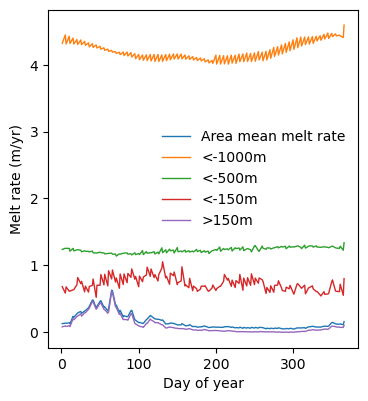

In [20]:
gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[4,9])
ax = None


ax = fig.add_subplot(gs[0,0])
ax.plot(ds_clima.dayofyear,(ds_clima.m*60*60*24*365*mask_zice).weighted(weights).mean(dim={'eta_rho','xi_rho'}),label='Area mean melt rate',color='C0',linestyle='-',linewidth=1)


ax.plot(ds_clima.dayofyear,(ds_clima.m*60*60*24*365*mask_zice.where(ds.zice<=-1000)).weighted(weights).mean(dim={'eta_rho','xi_rho'}),label='<-1000m',color='C1',linestyle='-',linewidth=1)
ax.plot(ds_clima.dayofyear,(ds_clima.m*60*60*24*365*mask_zice.where((ds.zice<=-500)&(ds.zice>-1000))).weighted(weights).mean(dim={'eta_rho','xi_rho'}),label='<-500m',color='C2',linestyle='-',linewidth=1)
ax.plot(ds_clima.dayofyear,(ds_clima.m*60*60*24*365*mask_zice.where((ds.zice<=-150)&(ds.zice>-500))).weighted(weights).mean(dim={'eta_rho','xi_rho'}),label='<-150m',color='C3',linestyle='-',linewidth=1)
ax.plot(ds_clima.dayofyear,(ds_clima.m*60*60*24*365*mask_zice.where((ds.zice>-150))).weighted(weights).mean(dim={'eta_rho','xi_rho'}),label='>150m',color='C4',linestyle='-',linewidth=1)

ax.legend(frameon=False)

ax.set_xlabel('Day of year')
ax.set_ylabel('Melt rate (m/yr)')